# Curation

In this tutorial we will show curate spike sorting results automatically using quality metrics and automatic labeling.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import json

import spikeinterface as si
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings("ignore")

In [4]:
%matplotlib widget

In [5]:
si.set_global_job_kwargs(n_jobs=0.5)

In [7]:
base_data_folder = Path("/home/pierre/data/cnn/raw_datas/")
working_folder = Path("/home/pierre/data/cnn/results")

In [8]:
sorter = "SC2"
recording_name = "M25_D23_2024-11-11_13-11-10_OF1"
results_folder = working_folder / recording_name

In [9]:
# load SortingAnalyzer from previous step
analyzer_folder = results_folder / f"analyzer_{sorter}"

if analyzer_folder.is_dir():
    print("Loading analyzer from disk")
    analyzer = si.load(analyzer_folder, load_extensions=True)
else:
    recording_preprocessed = si.load(f"preprocessed_{recording_name}")
    sorting = si.load(f"sorting_{sorter}_{recording_name}")
    analyzer = si.create_sorting_analyzer(sorting, recording_preprocessed)
    extension_dict = {
        "random_spikes": {},
        "noise_levels": {},
        "waveforms": {},
        "templates": {},
        "template_similarity": {"method": "l1"},
        "template_metrics": {"include_multi_channel_metrics": True},
        "correlograms": {},
        "unit_locations": {},
        "spike_amplitudes": {},
        "spike_locations": {"method": "grid_convolution"},
        "quality_metrics": {}
    }
    analyzer.compute(extension_dict)
    analyzer.save_as(folder=analyzer_folder, format="binary_folder")
analyzer

Loading analyzer from disk


SortingAnalyzer: 384 channels - 122 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extensions: templates, noise_levels, random_spikes, spike_amplitudes, unit_locations, waveforms, template_similarity, correlograms, template_metrics, spike_locations, quality_metrics

### Remove redundant units



In [10]:
sorting_clean = sc.remove_redundant_units(analyzer)
if len(sorting_clean.unit_ids) < len(analyzer.unit_ids):
    num_redundant = len(analyzer.unit_ids) - len(sorting_clean.unit_ids)
    print(f"Found {num_redundant} redundant units")
    analyzer = analyzer.select_units(sorting_clean.unit_ids)

Found 2 redundant units


In [11]:
num_uncurated_units = len(analyzer.unit_ids)

In [12]:
_ = sw.plot_unit_templates(analyzer, backend="ipywidgets")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

### Quality metric-based curation

This strategy for curation uses different thresholds on quality metrics. Quality metrics are designed to quantify different aspects of a unit, such as amplitude, SNR, drift, ISI violations, spike train completeness, and more.

A ful list of available quality metrics is available [here](https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html).

In [16]:
qm = analyzer.get_extension("quality_metrics").get_data()
print(f"Available metrics: {qm.columns.values}")

Available metrics: ['num_spikes' 'firing_rate' 'presence_ratio' 'snr' 'isi_violations_ratio'
 'isi_violations_count' 'rp_contamination' 'rp_violations'
 'sliding_rp_violation' 'amplitude_cutoff' 'amplitude_median'
 'amplitude_cv_median' 'amplitude_cv_range' 'sync_spike_2' 'sync_spike_4'
 'sync_spike_8' 'firing_range' 'drift_ptp' 'drift_std' 'drift_mad'
 'sd_ratio' 'noise_cutoff' 'noise_ratio']


`qm` is a `pandas.DataFrame` with unit ID as indices. We can easily perform a query with a quality-metric "recipe", such as:

In [17]:
curation_query = "rp_contamination < 0.2 and snr > 5 and presence_ratio > 0.8"

qm_filtered = qm.query(curation_query)
print(f"Number of units after curation: {len(qm_filtered)} / {len(qm)}")

Number of units after curation: 25 / 120


Let's see how they look! The `SortingAnalyzer` has a convenient function to select units and propagate all extensions:

In [18]:
units_to_keep = list(qm_filtered.index)
analyzer_qm_filt = analyzer.select_units(units_to_keep)

In [19]:
# we can also save the unit outputs 
passing_qc = np.zeros(len(analyzer.unit_ids), dtype=bool)
passing_qc[analyzer.sorting.ids_to_indices(units_to_keep)] = True
analyzer.set_sorting_property("passing_qc", passing_qc)

In [20]:
_ = sw.plot_unit_templates(analyzer_qm_filt, backend="ipywidgets")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

**NICE!!** Most of noisy units are gone, but we are also left with less than 70 units... maybe our curation was too strict?

### Automatic labeling

In the `curation` module we also provide some model-based automatic labeling of units. Specifically, we use pre-trained classifiers from hand-curated data from the [UnitRefine](https://www.biorxiv.org/content/10.1101/2025.03.30.645770v1) project. UniteRefine models use quality and template metrics to classify units as being `noise` or `neural` and `SUA` (single-unit activity) or `MUA` (multi-unit activity).

All available models are publicly available on the [SpikeInterface HuggingFace Organization](https://huggingface.co/SpikeInterface).

Let's see how to use them!

In [21]:
# sc.auto_label_units?

In [22]:
noise_neuron_labels = sc.auto_label_units(
    sorting_analyzer=analyzer,
    repo_id="SpikeInterface/UnitRefine_noise_neural_classifier_lightweight",
    trust_model=True,
)



best_model.skops:   0%|          | 0.00/5.58M [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

model_info.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [23]:
noise_neuron_labels

,prediction,probability
0,noise,0.808175
1,noise,0.500581
2,neural,0.748594
3,neural,0.662537
5,neural,0.698311
...,...,...
461,neural,0.738487
467,noise,0.603254
468,noise,0.625931
469,neural,0.538335


In [24]:
noise_units = noise_neuron_labels[noise_neuron_labels['prediction'] == 'noise']
analyzer_neural = analyzer.remove_units(list(noise_units.index))
analyzer_noise = analyzer.select_units(list(noise_units.index))

In [25]:
# Apply the sua/mua model
sua_mua_labels = sc.auto_label_units(
    sorting_analyzer=analyzer_neural,
    repo_id="SpikeInterface/UnitRefine_sua_mua_classifier_lightweight",
    trust_model=True,
)

unit_refine_labels = pd.concat([sua_mua_labels, noise_units]).sort_index()
sua_units = sua_mua_labels[sua_mua_labels['prediction'] == 'sua']
analyzer_sua = analyzer_neural.select_units(list(sua_units.index))
mua_units = sua_mua_labels[sua_mua_labels['prediction'] == 'mua']
analyzer_mua = analyzer_neural.select_units(list(mua_units.index))

best_model.skops:   0%|          | 0.00/8.13M [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

model_info.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

In [26]:
sua_mua_labels

,prediction,probability
2,mua,0.669051
3,mua,0.697728
5,mua,0.966640
13,mua,0.892123
24,mua,0.785632
...,...,...
444,mua,0.605084
451,sua,0.919515
461,sua,0.864295
469,mua,0.815582


In [27]:
# Let's see what we got
print(f"Noise units: {len(noise_units)} / {num_uncurated_units}")
print(f"MUA units: {len(mua_units)} / {num_uncurated_units}")
print(f"SUA units: {len(sua_units)} / {num_uncurated_units}")

Noise units: 26 / 120
MUA units: 68 / 120
SUA units: 26 / 120


In [28]:
# it is also convenient to store the label and the probability as properties of the sorting analyzer
analyzer.set_sorting_property("unitrefine_prediction", unit_refine_labels["prediction"])
analyzer.set_sorting_property("unitrefine_probability", unit_refine_labels["probability"])

In [29]:
_ = sw.plot_unit_templates(analyzer_noise, backend="ipywidgets")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [30]:
_ = sw.plot_unit_templates(analyzer_mua, backend="ipywidgets")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [31]:
_ = sw.plot_unit_templates(analyzer_sua, backend="ipywidgets")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [32]:
analyzer_to_process = analyzer_neural

### Auto-merging

Both quality metric-based and model-based curation provide labels for individual units. A common spike sorting mistake, however, is to *oversplit* units, i.e., multiple sorted units are actually from the same underlying neuron.

These errors are usually manually fixed with curation, but the curation module also provides some automated strategies to find potential merges. These strategies have different flavors, but usually use the similarity across templates and auto/cross correlogram shapes to make a merge decision.

See [compute_merge_unit_groups](https://spikeinterface.readthedocs.io/en/latest/api.html#spikeinterface.curation.compute_merge_unit_groups) function for documentation.

In [33]:
# sc.compute_merge_unit_groups?

In [ ]:
potential_merges = sc.compute_merge_unit_groups(
    analyzer_neural,
    preset="similarity_correlograms",
    steps_params={"template_similarity": {"template_diff_thresh": 0.5}}
)

In [ ]:
print(potential_merges)

In [138]:
#sw.plot_potential_merges(analyzer_neural, potential_merges=potential_merges, backend="ipywidgets")

### Curation format

We have seen that we can perform several curation actions: labeling units, removing units (usually noisy ones), and merge oversplits.

However, we haven't seen how represent and apply curation steps.
The `curation` module, for this purpose, defines a *curation format*, which is a standardized representation of the curation actions.

In this section we'll see how to formalize a curation, apply to an existing analyzer, and save it to a file that can be used by the [SpikeInterface-GUI](https://github.com/SpikeInterface/spikeinterface-gui), a powerful GUI for visualization and further curation refinement.

In [139]:
# we will use unitrefine labels as pre-computed "quality"
unitrefine_labels = analyzer.get_sorting_property("unitrefine_prediction")
unitrefine_labels[unitrefine_labels == "sua"] = "good"
unitrefine_labels[unitrefine_labels == "mua"] = "MUA"

label_definitions = {
    "quality": dict(name="quality", label_options=["good", "MUA", "noise"], exclusive=True),
}
manual_labels = [
    {"unit_id": unit_id, "labels": {"quality": [unitrefine_labels[unit_index]]}}
    for unit_index, unit_id in enumerate(analyzer.unit_ids)
]

In [140]:
curation_dict = dict(
    format_version="2",
    unit_ids=analyzer.unit_ids,
    label_definitions=label_definitions, 
    merges=[
        dict(unit_ids=p)
        for p in potential_merges
    ],
    removed=analyzer_noise.unit_ids,
    manual_labels=manual_labels
)

Now that we have a curation with all steps (remove, merge, label) we can apply it in one go!

In [141]:
from spikeinterface.curation import validate_curation_dict

In [142]:
validate_curation_dict(curation_dict)

In [143]:
# we can use the CurationModel for more secure serialization
from spikeinterface.curation.curation_model import CurationModel

curation = CurationModel(**curation_dict)
curation_file = Path("curation.json")
_ = curation_file.write_text(curation.model_dump_json(indent=4))

In [144]:
analyzer_curated = sc.apply_curation(analyzer, curation_dict, sparsity_overlap=0.5)
analyzer_sua.save_as(format='binary_folder', folder=results_folder / f"analyzer_{sorter}_sua")

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 25 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extensions: random_spikes, waveforms, templates, noise_levels, correlograms, template_metrics, unit_locations, template_similarity, spike_amplitudes, spike_locations, quality_metrics

### SpikeInterface-GUI curated

In [60]:
from spikeinterface_gui import run_mainwindow

In [61]:
run_mainwindow(
    analyzer_sua,
    displayed_unit_properties=["passing_qc", "unitrefine_prediction", "unitrefine_probability"],
    curation=True,
    mode="desktop"
)

<spikeinterface_gui.backend_qt.QtMainWindow(0x84220860) at 0x7725899dc0c0>

### Comparing curated sortings

In [145]:
import spikeinterface.full as si
sorting_KS4 = si.load(results_folder / "analyzer_KS4_sua").sorting
print(sorting_KS4)
sorting_SC2 = si.load(results_folder / "analyzer_SC2_sua").sorting
print(sorting_SC2)
sorting_TDC2 = si.load(results_folder / "analyzer_TDC2_sua").sorting
print(sorting_TDC2)
multi_comp = si.compare_multiple_sorters(
    sorting_list=[sorting_KS4, sorting_SC2, sorting_TDC2],
    name_list=['KS4', 'SC2', 'TDC2'],
    spiketrain_mode='union',
    verbose=True
)

NumpySorting: 82 units - 1 segments - 30.0kHz
NumpySorting: 37 units - 1 segments - 30.0kHz
NumpySorting: 25 units - 1 segments - 30.0kHz
Multicomparison step 1: pairwise comparison
Multicomparison step 2: make graph
Multicomparison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


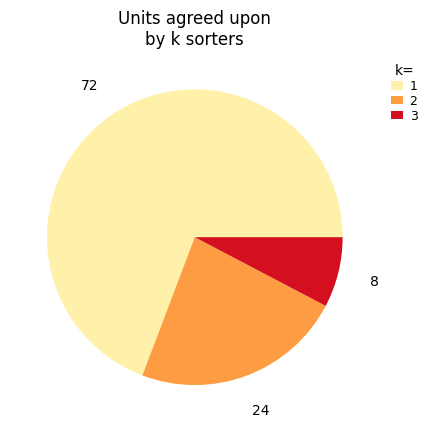

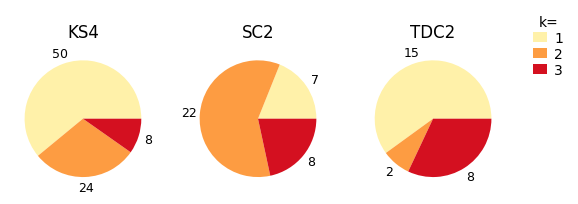

In [149]:
%matplotlib inline
w = si.plot_multicomparison_agreement(multi_comp)
w = si.plot_multicomparison_agreement_by_sorter(multi_comp)